# Step 4.1 — Data parsing & cleaning (TSLA daily)

**Goal.** Load daily OHLC data for **TSLA**, standardize it, and produce a clean **Close** price series ready for log-returns and calibration.

**Input (file):** `GeometricBrownianMotion\data\daily\tsla.us.txt`
Format (no header, comma-separated):
`<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>`

* We’ll parse `DATE`+`TIME` → a proper datetime index.
* We’ll keep **CLOSE** as the working price (if you have **Adjusted Close** elsewhere, prefer that).
* Period is already **daily** (`PER = D`), so the time step is

  $$
  \Delta t = \frac{1}{252}\ \text{(trading years)}.
  $$

**What we produce now:** a tidy DataFrame indexed by date with columns
`Close, Open, High, Low, Volume, OpenInt`.

**Minimal formulas used later (recap; see earlier notebooks for derivations):**

* **Log-returns:** $r_t = \ln S_t - \ln S_{t-1}$.
* **Estimators (from Step 2):**

  $$
  \hat\sigma = \sqrt{\frac{\operatorname{Var}(r)}{\Delta t}},\qquad
  \hat\mu = \frac{\overline{r}}{\Delta t} + \tfrac12\,\hat\sigma^{2}.
  $$
* **Exact GBM step (from Step 3):**

  $$
  S_{k+1}=S_k\exp\!\Big((\mu-\tfrac12\sigma^2)\Delta t+\sigma\sqrt{\Delta t}\,Z_k\Big),\quad Z_k\sim\mathcal N(0,1).
  $$

**Sanity checks to remember:**

* Prices must be **positive** (logs need $S_t>0$).
* Dates strictly increasing; **no duplicates** per day.
* Handle or flag **missing Close**; if not using **Adjusted Close**, note that splits/dividends can create large one-day moves (we’ll flag outliers later).

In [4]:
import pandas as pd
import numpy as np

# ---- Settings ----
CSV_PATH = r"./data/daily/tsla.us.txt"  # raw string for backslashes on Windows
TRADING_DAYS_PER_YEAR = 252
DELTA_T = 1.0 / TRADING_DAYS_PER_YEAR



# ---- Load & clean a single-file (TSLA) in your format ----
def load_single_ohlc_file(csv_path: str):
    cols = ["TICKER","PER","DATE","TIME","OPEN","HIGH","LOW","CLOSE","VOL","OPENINT"]
    df = pd.read_csv(csv_path, header=None, names=cols)

    # Keep daily rows (PER == 'D'), drop rows without CLOSE
    df = df[df["PER"].astype(str).str.upper().eq("D")].copy()
    df = df.dropna(subset=["CLOSE"])

    # Build datetime index from DATE (YYYYMMDD) + TIME (HHMMSS)
    dt_str = df["DATE"].astype(str).str.zfill(8) + df["TIME"].astype(str).str.zfill(6)
    df["DateTime"] = pd.to_datetime(dt_str, format="%Y%m%d%H%M%S", errors="coerce")

    # Standardize column names (lowercase), set index, sort, drop duplicates
    df = df.rename(columns={
        "TICKER":"ticker","PER":"per","OPEN":"open","HIGH":"high",
        "LOW":"low","CLOSE":"close","VOL":"volume","OPENINT":"openint"
    })
    df = df.dropna(subset=["DateTime"]).set_index("DateTime").sort_index()
    df = df[~df.index.duplicated(keep="last")]

    # Cast numerics and keep typical columns
    for c in ["open","high","low","close","volume","openint"]:
        if c in df:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Enforce positive close, drop remaining NaNs in close
    df = df[df["close"] > 0].dropna(subset=["close"])

    # Final tidy frame
    out = df[["close","open","high","low","volume","openint"]].copy()
    out.rename(columns=str.capitalize, inplace=True)  # Close, Open, High, Low, Volume, Openint
    return out

tsla = load_single_ohlc_file(CSV_PATH)

# ---- Quick sanity report ----
def sanity_report(g: pd.DataFrame):
    return pd.DataFrame({
        "rows": [len(g)],
        "start": [g.index.min()],
        "end": [g.index.max()],
        "missing_close": [g["Close"].isna().sum()],
        "nonpos_close": [(g["Close"] <= 0).sum()]
    })

rep = sanity_report(tsla)
display(rep)
display(tsla.head(3))
display(tsla.tail(3))

,rows,start,end,missing_close,nonpos_close
0,3813,2010-06-28,2025-08-25,0,0


,Close,Open,High,Low,Volume,Openint
DateTime,,,,,,
2010-06-28,1.13333,1.13333,1.13333,1.13333,0,0
2010-06-29,1.59267,1.26667,1.66667,1.16933,281749140,0
2010-06-30,1.58867,1.71933,2.02800,1.55333,257915910,0


,Close,Open,High,Low,Volume,Openint
DateTime,,,,,,
2025-08-21,320.11,322.08,324.90,318.68,55744445,0
2025-08-22,340.01,321.66,340.25,319.69,94016347,0
2025-08-25,346.60,338.90,349.53,335.03,86364495,0


# Step 4.2 — Daily log-returns & calibration (TSLA)

**Goal.** Turn prices into **log-returns** and estimate the GBM parameters $\mu$ (drift) and $\sigma$ (volatility) for daily data.

**Data → returns.** With daily **Close** prices $S_t$ and trading-year step

$$
\Delta t=\frac{1}{252},
$$

we define one-step log-returns

$$
r_t=\ln S_t-\ln S_{t-1}.
$$

**GBM recap (see Steps 2 & 3 for derivations).** Under GBM,

$$
dS_t=\mu S_t\,dt+\sigma S_t\,dW_t \quad\Rightarrow\quad
\Delta\ln S \sim \mathcal N\!\big((\mu-\tfrac12\sigma^2)\Delta t,\ \sigma^2\Delta t\big).
$$

Hence the **method-of-moments** estimators from sample returns $\{r_t\}$ are

$$
\hat\sigma=\sqrt{\frac{\operatorname{Var}(r)}{\Delta t}},
\qquad
\hat\mu=\frac{\overline{r}}{\Delta t}+\tfrac12\,\hat\sigma^{\,2}.
$$

Notes:

* $\hat\mu$ is the **level drift** (annualized). The **mean log-return per year** is $\hat\mu-\tfrac12\hat\sigma^2$.
* $\hat\sigma$ is **annualized vol**; daily vol is $\hat\sigma/\sqrt{252}$.

**What we’ll use these for next.**

* Build **prediction bands** and event probabilities at horizons $T$.
* Run **diagnostics**: histogram vs Normal, ACF of $r_t$ and $r_t^2$, QQ-plot (to see where GBM fits/fails).
* Monte Carlo **scenario generation** (exact GBM step).

**Sanity reminders.**

* Prices $S_t$ must be **positive**; dates must be sorted and unique.
* Without **Adjusted Close**, corporate actions can create extreme one-day moves. We’ll flag big |$r_t$| as a heads-up.

,value
obs_n,3812
daily_mean_r,0.001501
daily_sd_r,0.036805
annual_mu_hat,0.549008
annual_sigma_hat,0.584255
annual_mean_log_return (mu - 0.5*sigma^2),0.378331
sample_start,2010-06-29 00:00:00
sample_end,2025-08-25 00:00:00



Large |daily log-return| > 15%: 26 days


DateTime
2010-06-29    0.340252
2020-09-08   -0.236518
2013-05-09    0.218294
2012-01-13   -0.214772
2020-03-16   -0.205487
2025-04-09    0.204491
2024-10-24    0.198187
2020-02-05   -0.188440
2020-02-03    0.181476
2021-03-09    0.179327
Name: r, dtype: float64

,Close,r
DateTime,,
2025-08-19,329.31,-0.017608
2025-08-20,323.90,-0.016565
2025-08-21,320.11,-0.011770
2025-08-22,340.01,0.060310
2025-08-25,346.60,0.019196


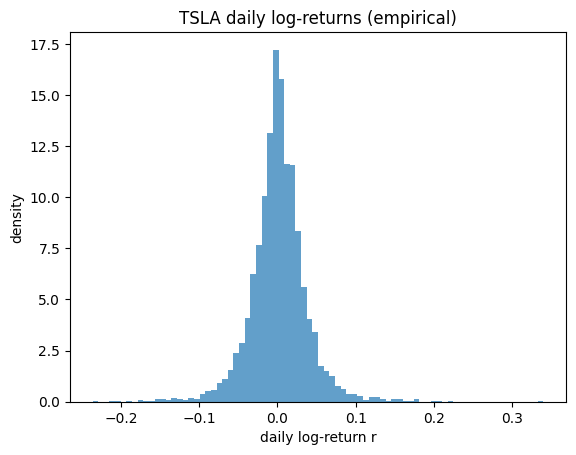

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS_PER_YEAR = 252
DELTA_T = 1.0 / TRADING_DAYS_PER_YEAR

# tsla DataFrame is assumed loaded from Step 4.1 and has a DateTime index + "Close" column
assert "Close" in tsla.columns, "Expected a 'Close' column in tsla DataFrame."

# --- 1) Daily log-returns ---
ret = np.log(tsla["Close"]).diff().dropna().rename("r")  # r_t = ln S_t - ln S_{t-1}
n = ret.shape[0]

# Basic stats (daily)
r_bar = ret.mean()
r_var = ret.var(ddof=1)
r_sd  = np.sqrt(r_var)

# --- 2) Calibrate (annualized μ, σ) via method-of-moments ---
sigma_hat = np.sqrt(r_var / DELTA_T)        # annualized volatility
mu_hat    = (r_bar / DELTA_T) + 0.5*sigma_hat**2  # level drift (annualized)
log_drift_hat = mu_hat - 0.5*sigma_hat**2         # mean log-return per year

summary = pd.Series({
    "obs_n": n,
    "daily_mean_r": r_bar,
    "daily_sd_r": r_sd,
    "annual_mu_hat": mu_hat,
    "annual_sigma_hat": sigma_hat,
    "annual_mean_log_return (mu - 0.5*sigma^2)": log_drift_hat,
    "sample_start": ret.index.min(),
    "sample_end": ret.index.max()
})
display(summary.to_frame("value"))

# --- 3) Quick outlier scan (big absolute daily moves) ---
# Adjust the threshold if you want to be stricter/looser
thr = 0.15  # 15% daily log-return magnitude ≈ large move
outliers = ret[np.abs(ret) > thr].sort_values(key=np.abs, ascending=False)
print(f"\nLarge |daily log-return| > {thr:.0%}: {outliers.size} days")
display(outliers.head(10))

# (Optional) Peek at a small summary table
peek = pd.DataFrame({
    "Close": tsla["Close"].iloc[-5:],
    "r": ret.iloc[-5:]
})
display(peek)

# (Optional) Small histogram to visualize scale (using empirical mean/var)
plt.figure()
plt.hist(ret, bins=80, density=True, alpha=0.7)
plt.xlabel("daily log-return r")
plt.ylabel("density")
plt.title("TSLA daily log-returns (empirical)")
plt.show()

* **N = 3,812 daily returns** (2010-06-29 → 2025-08-25).
* **Daily mean r ≈ 0.00150** (≈ **0.15%/day**).
* **Daily sd ≈ 3.68%** ⇒ **annual σ̂ ≈ 58.4%** (big, but TSLA is volatile).
* **Annual μ̂ ≈ 54.9%** and **annual mean log-return (μ − ½σ²) ≈ 37.8%**.
* **26 days with |r| > 15%** → expect **fat tails** beyond Normal.

## Step 4.3 — Diagnostics (what to check next)

**Goal.** Check if GBM’s one-step assumptions fit TSLA’s **daily log-returns**:

* Shape: Normal with mean $(\hat\mu - \tfrac12 \hat\sigma^2)\,\Delta t$, variance $\hat\sigma^2\,\Delta t$.  
* Independence of returns.  
* No volatility clustering (often fails on real data).  

We’ll plot:

1. Histogram with **Normal overlay** using the **theoretical** daily mean/variance implied by $(\hat\mu,\hat\sigma)$.  
2. **QQ-plot** vs Normal.  
3. **ACF** of returns $r_t$ and of squared returns $r_t^2$ (first 20 lags, 95% bands).


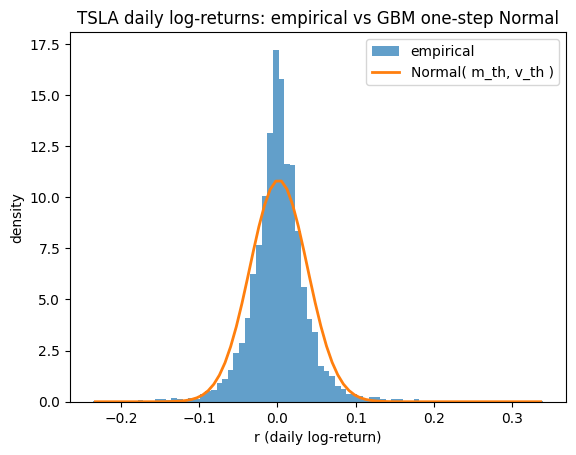

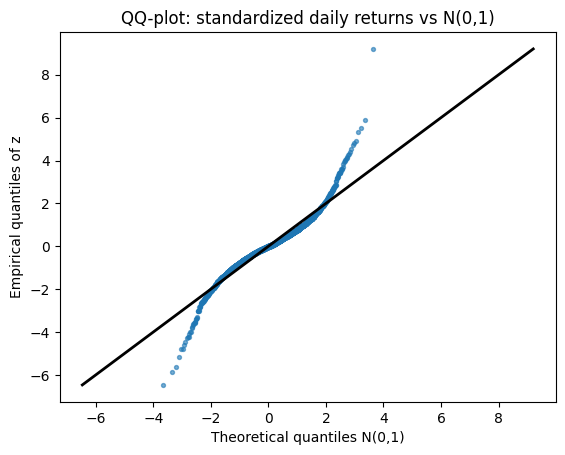

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Assumes: ret (Series of daily log-returns), DELTA_T, mu_hat, sigma_hat from 4.2

# --- 1) Histogram with Normal overlay (theoretical daily params) ---
m_th = (mu_hat - 0.5*sigma_hat**2) * DELTA_T     # theory mean of daily log-return
v_th = (sigma_hat**2) * DELTA_T                  # theory variance of daily log-return
sd_th = np.sqrt(v_th)

plt.figure()
count, bins, _ = plt.hist(ret, bins=80, density=True, alpha=0.7, label="empirical")
centers = 0.5*(bins[:-1]+bins[1:])
pdf = (1.0/(sd_th*np.sqrt(2*np.pi))) * np.exp(-0.5*((centers - m_th)/sd_th)**2)
plt.plot(centers, pdf, linewidth=2, label="Normal( m_th, v_th )")
plt.title("TSLA daily log-returns: empirical vs GBM one-step Normal")
plt.xlabel("r (daily log-return)")
plt.ylabel("density")
plt.legend()
plt.show()

# --- 2) QQ-plot vs Normal(m_th, v_th) ---
# We'll standardize: z = (r - m_th)/sd_th, then compare to standard Normal quantiles.
z = (ret - m_th) / sd_th
z_sorted = np.sort(z.values)
p = (np.arange(1, len(z_sorted)+1) - 0.5) / len(z_sorted)
q_theory = norm.ppf(p)# inverse CDF of N(0,1) without external libs

plt.figure()
plt.scatter(q_theory, z_sorted, s=8, alpha=0.6)
lims = [min(q_theory.min(), z_sorted.min()), max(q_theory.max(), z_sorted.max())]
plt.plot(lims, lims, 'k-', linewidth=2)
plt.title("QQ-plot: standardized daily returns vs N(0,1)")
plt.xlabel("Theoretical quantiles N(0,1)")
plt.ylabel("Empirical quantiles of z")
plt.show()

# --- 3) ACF of r_t and r_t^2 (first 20 lags) ---
def acf(x, max_lag=20):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    denom = np.dot(x, x)
    ac = [1.0]
    for k in range(1, max_lag+1):
        num = np.dot(x[:-k], x[k:])
        ac.append(num/denom)
    return np.array(ac)

lags = np.arange(0, 21)
acf_r  = acf(ret.values, max_lag=20)
acf_r2 = acf((ret.values**2), max_lag=20)

# 95% approx confidence band for zero-ACF: ±1.96/sqrt(n)
band = 1.96/np.sqrt(len(ret))

def stem_compat(x, y, color="C0", title="", ylabel="ACF"):
    markerline, stemlines, baseline = plt.stem(x, y)   # no use_line_collection (compat)
    plt.setp(stemlines, color=color, linewidth=1.5)
    plt.setp(markerline, color=color, markersize=4)
    plt.setp(baseline, color='k', linewidth=1)
    plt.hlines([band, -band], x.min(), x.max(), linestyles="dashed")
    plt.title(title)
    plt.xlabel("lag (days)")
    plt.ylabel(ylabel)

plt.figure()
stem_compat(lags, acf_r, color="C0", title="ACF of daily log-returns r_t")
plt.show()

plt.figure()
stem_compat(lags, acf_r2, color="C1", title="ACF of squared daily returns r_t^2")
plt.show()

## How to read the plots

* **Histogram + overlay:** center and width should match well; **tails** will likely exceed the Normal curve (fat tails).
* **QQ-plot:** points on the 45° line = perfect Normal; **S-shaped curve / tail lift** = heavy tails vs Normal (common for equities).
* **ACF(r):** should hover near 0 (no linear predictability).
* **ACF(r²):** often **positive** at short lags → **volatility clustering**, which GBM doesn’t model.